# License Registration Recognition

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_img(img):
    plt.imshow(img)
    plt.show()

In [20]:
image = io.imread('slike_rega/24797146.jpg')

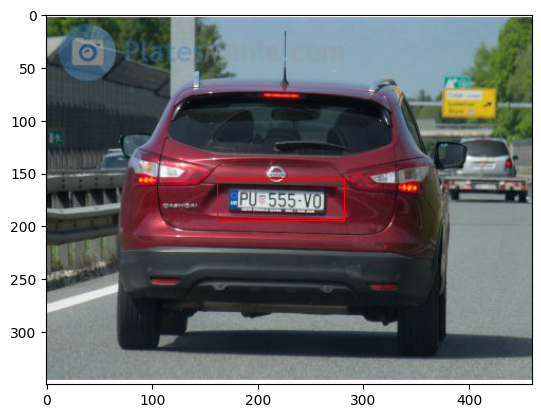

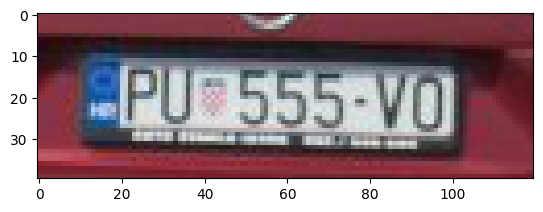

In [21]:
def detect_plate(img):
    plate_cascade = cv2.CascadeClassifier('./cascade/haarcascade_plate_number.xml')
    img_rect = img.copy()
    roi = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plates = plate_cascade.detectMultiScale(gray, 1.1, 4)
    plate_imgs = []
    
    for (x, y, w, h) in plates:
        plate_imgs.append(roi[y:y+h, x:x+w, :])
        cv2.rectangle(img_rect, (x, y), (x+w, y+h), (255, 0, 0), 1)
    return img_rect, plate_imgs

detected_plate, plate_imgs = detect_plate(image)
show_img(detected_plate)
show_img(plate_imgs[0])
    

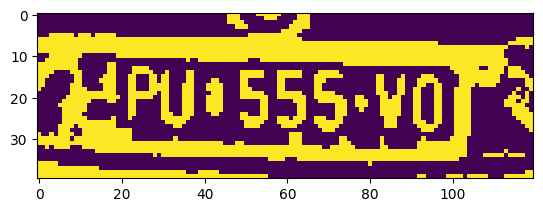

In [19]:
image = plate_imgs[0]

# Konvertovanje slike u sivi nivo
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Primena Gaussian blur-a
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Primena adaptivnog thresholding-a
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Definisanje kernel-a za morfološke operacije
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Primena dilatacije i erozije
dilated = cv2.dilate(thresh, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

show_img(thresh)